In [1]:
from databaseCommunication import readDatabaseFile, createDataFrame_list
from dataframeFormating import createLabeledDataFrame_list #, N_polarized_pure3b, N_polarized, N_linear, getReducedDataframe, getReducedResults, 
from calculation import trapFrequency, getSubDF, noiseFilter, renameUnits, dropExcluded, computeBareTrapFrequencies, computeTrapFrequencies
from fit import fitDF, N_polarized_pure3b, N_polarized, N_linear, N_polarized_premix, fitRun_pure_premix, fitRun_pure, fitRun_mix, fitRun_lin, N_1b
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

In [2]:
label_heads = ['atomicBeamShutter', 'ODTPowerInit', 'Bz', 'experiment']

labels = [[['On', 'High', 7.4, 'wholeCurve'], [178054, 178185]],
          [['On', 'High', 7.4, 'longTerm'], [178191, 178232]],
          [['On', 'High', np.nan, 'fieldScan'], [179058, 179201]]
             ] # June 29th
# ODT1 power = 1 // ODT2 Power = 1 // ODT 3 Power = 5
# 1st run: The sequence is as usual
# 2nd run: zoom at long time to determine alpha
# 3rd run: tried to reduce the initial ODT power to increase atom number stability

excluded = [178133, 178148, 178185, 178204, 178231, 178132]

In [3]:
"""ciceroVariables = ['BECShapeTime', 'TOF', 'compz_rotation']
fitVariables = ['nCount', 'xWidth', 'yWidth']

df = createLabeledDataFrame_list(labels, label_heads, ciceroVariables, fitVariables)
for column in df.columns:
    try:
        df[column] = df[column].astype(float)
    except:
        pass
df.to_pickle('data_save_ODT_210529_ODT.pickle')"""

"ciceroVariables = ['BECShapeTime', 'TOF', 'compz_rotation']\nfitVariables = ['nCount', 'xWidth', 'yWidth']\n\ndf = createLabeledDataFrame_list(labels, label_heads, ciceroVariables, fitVariables)\nfor column in df.columns:\n    try:\n        df[column] = df[column].astype(float)\n    except:\n        pass\ndf.to_pickle('data_save_ODT_210529_ODT.pickle')"

In [82]:
df = pd.read_pickle('data_save_ODT_210529_ODT.pickle')
renameUnits(df, magnification = 4.38, cameraPixelSize = 6.5, axis = 'horizontal', experiment = 'TOF')
df.rename(columns = {'compz_rotation' : 'compz'}, inplace = True)
df.rename(columns = {'BECShapeTime' : 'BECHoldTime'}, inplace = True)
indexNames = pd.Index(np.where(df['imageID'].isin(excluded))[0])
df.drop(indexNames, inplace = True)

m = 164*1.67*10**(-27)
k_B = 1.38*10**(-23)
hbar = 6.626*10**(-34)/(2*np.pi)
sigma_0 = 4

df['temperature'] = (m/k_B*((df['xWidth_TOF_h_um'])**2-sigma_0**2)*(10**(-12))/(df['TOF']**2*10**(-6)))/(10**(-9)) # in nano kelvin
df_3b = df[df['experiment'] == 'wholeCurve']
df_alpha = df[df['experiment'] == 'longTerm']
df_fieldScan = df[df['experiment'] == 'fieldScan']
#df_alpha = df[df['experiment'] == 'wholeCurve']
#df_alpha = df_alpha[df_alpha['BECHoldTime'] <= 20000]
#df_alpha = df_alpha[df_alpha['BECHoldTime'] >= 5000]

In [84]:
BECHoldTimeList = np.sort(df['BECHoldTime'].unique())
compzList = np.sort(df['compz'].unique())
colors = ['red', 'blue', 'orange', 'black', 'green']

In [85]:
BECHoldTimeList
compz = 7.4

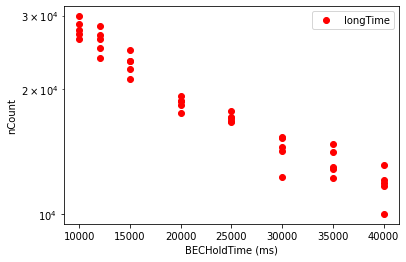

In [86]:
plt.figure()
df_temp = df_alpha
plt.semilogy(df_temp['BECHoldTime'], df_temp['nCount'], 'o', color = colors[0], label = str('longTime'))
plt.legend()
#plt.ylim(0,25000)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

In [87]:
"""def N_polarized(t, N0, alpha, gamma):
    return np.sqrt(alpha / (np.exp(2*alpha*t)*(alpha/(N0**2)+gamma)-gamma))

def N_linear(t, N0, b):
    return N0-b*t

def N_polarized_pure3b(t, N0, gamma):
    return N0 / np.sqrt(1+N0**2*gamma*t)

def N_1b(t, N0, alpha):
    return N0*np.exp(-alpha*t)

def N_polarized_alpha(t, N0, gamma):
    global alpha
    return np.sqrt(alpha / (np.exp(2*alpha*t)*(alpha/(N0**2)+gamma)-gamma))


def fitRun(df_run):
    N0_guess = max(df_run['nCount'])
    time_guess = max(df_run['BECHoldTime'])
    alpha_guess = 1/time_guess
    gamma_guess = 1/(N0_guess**2*time_guess)
    popt, pcov = curve_fit(N_polarized, df_run['BECHoldTime'], df_run['nCount'],
                       p0 = [N0_guess, alpha_guess, gamma_guess],
                          )#bounds = ((N0_guess/10, alpha_guess/10, gamma_guess/100), (N0_guess*10, alpha_guess*10, gamma_guess*100)),
                           #method = 'trf'
                      #)
    return popt, pcov

def fitRun_pure(df_run):
    N0_guess = max(df_run['nCount'])
    time_guess = max(df_run['BECHoldTime'])
    popt, pcov = curve_fit(N_polarized_pure3b, df_run['BECHoldTime'], df_run['nCount'],
                       p0 = [N0_guess, 1/(N0_guess**2*time_guess)],
                          )#bounds = ((0, 0), (np.inf, np.inf)),
                           #method = 'trf'
                      #)
    return popt, pcov

def fitRun_lin(df_run):
    N0_guess = max(df_run['nCount'])
    time_guess = max(df_run['BECHoldTime'])
    popt, pcov = curve_fit(N_linear, df_run['BECHoldTime'], df_run['nCount'],
                       p0 = [N0_guess, N0_guess/time_guess],
                          )#bounds = ((0, 0), (np.inf, np.inf)),
                           #method = 'trf'
                      #)
    return popt, pcov

def fitRun_pure_alpha(df_run):
    N0_guess = max(df_run['nCount'])
    time_guess = max(df_run['BECHoldTime'])
    gamma_guess = 1/(N0_guess**2*time_guess)
    popt, pcov = curve_fit(N_polarized_alpha, df_run['BECHoldTime'], df_run['nCount'],
                       p0 = [N0_guess, gamma_guess],
                          )#bounds = ((N0_guess/10, alpha_guess/10, gamma_guess/100), (N0_guess*10, alpha_guess*10, gamma_guess*100)),
                           #method = 'trf'
                      #)
    return popt, pcov"""

"def N_polarized(t, N0, alpha, gamma):\n    return np.sqrt(alpha / (np.exp(2*alpha*t)*(alpha/(N0**2)+gamma)-gamma))\n\ndef N_linear(t, N0, b):\n    return N0-b*t\n\ndef N_polarized_pure3b(t, N0, gamma):\n    return N0 / np.sqrt(1+N0**2*gamma*t)\n\ndef N_1b(t, N0, alpha):\n    return N0*np.exp(-alpha*t)\n\ndef N_polarized_alpha(t, N0, gamma):\n    global alpha\n    return np.sqrt(alpha / (np.exp(2*alpha*t)*(alpha/(N0**2)+gamma)-gamma))\n\n\ndef fitRun(df_run):\n    N0_guess = max(df_run['nCount'])\n    time_guess = max(df_run['BECHoldTime'])\n    alpha_guess = 1/time_guess\n    gamma_guess = 1/(N0_guess**2*time_guess)\n    popt, pcov = curve_fit(N_polarized, df_run['BECHoldTime'], df_run['nCount'],\n                       p0 = [N0_guess, alpha_guess, gamma_guess],\n                          )#bounds = ((N0_guess/10, alpha_guess/10, gamma_guess/100), (N0_guess*10, alpha_guess*10, gamma_guess*100)),\n                           #method = 'trf'\n                      #)\n    return popt, pc

In [88]:
compz = 7.4
df_3b_fit = df_3b[df_3b['BECHoldTime']<=1000]

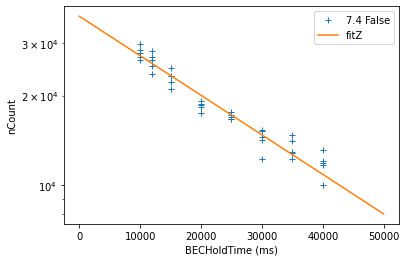

In [89]:
popt, pcov = curve_fit(N_1b, df_alpha['BECHoldTime'], df_alpha['nCount'], p0 = [df_alpha['nCount'].max(), 1/df_alpha['BECHoldTime'].max()])
N0, alpha = popt

time_long = np.linspace(0, 50000, 10000)
Z = N_1b(time_long, N0, alpha)
df_tempZ = getSubDF(df_alpha, ['compz'], [compz])

plt.figure()
plt.semilogy(df_tempZ['BECHoldTime'], df_tempZ['nCount'], '+', label = str(compz) + ' ' + str(False))
plt.semilogy(time_long, Z, '-', label = 'fitZ')
plt.legend()
#plt.ylim(0, 20000)
#plt.xlim(0,10)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

In [90]:
print("This fixes the value of alpha to " + str(round(alpha, 6)))

This fixes the value of alpha to 3.1e-05


In [91]:
1/(alpha*1000)

32.67570501357327

In [92]:
df = df_3b_fit
results = []
results_pure = []
results_lin = []
results_pure_alpha = []


for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt, pcov = fitRun_mix(df_run)
        results += [{'N0' : popt[0],
                    'alpha' : min(-10**(-10), popt[1]),
                    'gamma' : popt[2],
                     'compz' : compz
                    }]
resultsDF = pd.DataFrame(results)

for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt, pcov = fitRun_pure(df_run)
        results_pure += [{'N0' : popt[0],
                        'alpha' : 0,
                         'gamma' : popt[1],
                          'compz' : compz
                    }]
resultsDF_pure = pd.DataFrame(results_pure)

for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt, pcov = fitRun_lin(df_run, tmax_ms = np.inf)
        results_lin += [{'N0' : popt[0],
                         'b' : popt[1],
                         'compz' : compz
                    }]
resultsDF_lin = pd.DataFrame(results_lin)

for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt, pcov = fitRun_pure_premix(df_run)
        results_pure_alpha += [{'N0' : popt[0],
                    'alpha' : alpha,
                    'gamma' : popt[1],
                     'compz' : compz
                    }]
resultsDF_pure_alpha = pd.DataFrame(results_pure_alpha)

In [93]:
resultsDF_pure_alpha

,N0,alpha,gamma,compz
0,44130.557354,0.000031,3.677752e-14,7.4


In [94]:
compz = 7.4
df_tempZ = getSubDF(df_3b, ['compz'], [compz])
time = np.linspace(0, 10000, 10000)

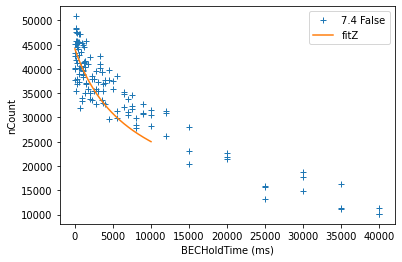

In [95]:
resultZ = getSubDF(resultsDF_pure, ['compz'], [compz])

NZ, alphaZ, gammaZ = resultZ[['N0', 'alpha', 'gamma']].iloc[0,:]
Z = N_polarized_pure3b(time, NZ, gammaZ)

plt.figure()
plt.plot(df_tempZ['BECHoldTime'], df_tempZ['nCount'], '+', label = str(compz) + ' ' + str(False))
plt.plot(time, Z, '-', label = 'fitZ')
plt.legend()
#plt.ylim(0, 20000)
#plt.xlim(0,10)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

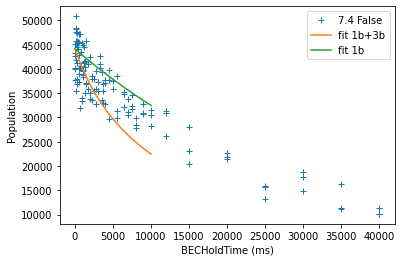

In [180]:
resultZ = getSubDF(resultsDF_pure_alpha, ['compz'], [compz])

NZ, gammaZ = resultZ[['N0', 'gamma']].iloc[0,:]

Z = N_polarized_premix(time, NZ, gammaZ)
Z2 = N_1b(time, NZ, alpha)


plt.figure()
plt.plot(df_tempZ['BECHoldTime'], df_tempZ['nCount'], '+', label = str(compz) + ' ' + str(False))
plt.plot(time, Z, '-', label = 'fit 1b+3b')
plt.plot(time, Z2, '-', label = 'fit 1b')
plt.legend()
#plt.ylim(0,20000)
#plt.xlim(0,10)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('Population')
plt.savefig("population_long.jpg", dpi = 300)
plt.show()

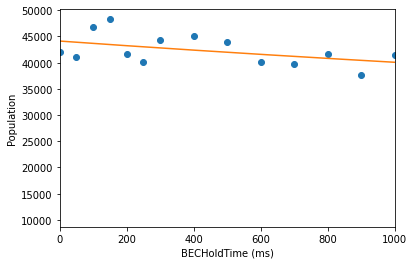

In [179]:
df_temp = df_3b.groupby(['BECHoldTime']).mean().reset_index()
plt.figure()
plt.plot(df_temp['BECHoldTime'], df_temp['nCount'], 'o')
plt.plot(time, Z, '-', label = 'fit 1b+3b')
plt.xlim(0, 1000)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('Population')
plt.savefig("population_initial.jpg", dpi = 300)
plt.show()

Let's use only the pure 3b fit

In [98]:
#results = resultsDF_pure
results = resultsDF_pure_alpha

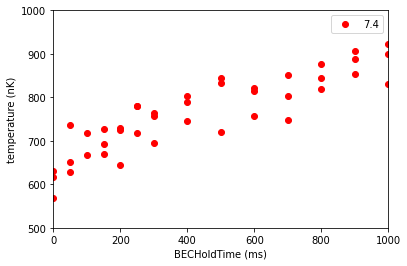

In [178]:
plt.figure()
i = 0
for compz in [7.4]:
    df_temp = getSubDF(df_3b, ['compz'], [compz])
    plt.plot(df_temp['BECHoldTime'], df_temp['temperature'], 'o', color = colors[i], label = str(compz))
    i += 1
plt.legend()
plt.xlim(0,1000)
plt.ylim(500,1000)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('temperature (nK)')
plt.savefig("temperature_initial.jpg", dpi = 300)
plt.show()

### Density measurement based on temperature and trap frequency

In the BEC the density is like $n(x, y, z) = K e^{-\frac{\frac{1}{2}m(\omega_x^2 x^2 + \omega_y^2 y^2 + \omega_z^2 z^2)}{k_B T}} = N\omega_x\omega_y\omega_z\left(\frac{m}{2\pi k_B T}\right)^{3/2} e^{-\frac{\frac{1}{2}m(\omega_x^2 x^2 + \omega_y^2 y^2 + \omega_z^2 z^2)}{k_B T}} = n_0 e^{-\frac{\frac{1}{2}m(\omega_x^2 x^2 + \omega_y^2 y^2 + \omega_z^2 z^2)}{k_B T}}$

In [108]:
#omega_x = 2*np.pi*220
#omega_y = 2*np.pi*90
#omega_z = 2*np.pi*220

#omega_x = 2*np.pi*70*np.sqrt(8)
#omega_y = 2*np.pi*28*np.sqrt(8)
#omega_z = 2*np.pi*50*np.sqrt(8)
omega_x = 2*np.pi*330 # omega_x
omega_y = 2*np.pi*207 # omega_y
omega_z = 2*np.pi*235 # omega_z

prefactor = omega_x*omega_y*omega_z*(m/(2*np.pi*k_B))**(3/2)
results['temperature'] = df_3b[df_3b['BECHoldTime'] == 0]['temperature'].mean()*10**(-9)
results['density'] = results['N0']*prefactor/(results['temperature'])**(3/2)*10**(-6)  # in atoms / cm3

By definition $<n^2> = \int n^2p(x, y, z)d\tau = \frac{1}{N}\int n^3 d\tau = N^2 (\omega_x\omega_y\omega_z)^2\frac{1}{\sqrt{27}}\left(\frac{m}{2\pi k_B T}\right)^3 = \frac{N^2}{\sqrt{27}(2\pi)^3(\sigma_x\sigma_y\sigma_z)^2}$. The differential equation formula is: $\frac{dN}{dt} = -\gamma N^3$ in the fit, but $\frac{dN}{dt} = -\beta <n^2> N$ in reality, so $\frac{dN}{dt} = -\beta \frac{N^2}{\alpha} N$ with $\alpha = 3^{3/2}\left(\frac{2\pi k_B T}{m}\right)^3\frac{1}{(\omega_x\omega_y\omega_z)^2} = 3^{3/2}(2\pi)^3(\sigma_x\sigma_y\sigma_z)^2 = \frac{3^{3/2}}{(n_0/N)^2}$, so $\beta = \gamma\alpha$

In [109]:
results['beta'] = results['gamma']*10**3*3**(3/2)/(results['density']/results['N0'])**2 # this is is cm^6/s

In [160]:
results

,N0,alpha,gamma,compz,temperature,density,beta
0,44130.557354,0.000031,3.677752e-14,7.4,6.058278e-07,6.615451e+13,8.504019e-29


# Temperature and atom number fit

In [132]:
df = df_fieldScan
#results = []
#results_pure = []
results_lin_fieldScan = []
#results_pure_alpha = []


"""for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt, pcov = fitRun(df_run)
        results += [{'N0' : popt[0],
                    'alpha' : min(-10**(-10), popt[1]),
                    'gamma' : popt[2],
                     'compz' : compz
                    }]
resultsDF = pd.DataFrame(results)

for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt, pcov = fitRun_pure(df_run)
        results_pure += [{'N0' : popt[0],
                        'alpha' : 0,
                         'gamma' : popt[1],
                          'compz' : compz
                    }]
resultsDF_pure = pd.DataFrame(results_pure)

for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt, pcov = fitRun_pure_alpha(df_run)
        results_pure_alpha += [{'N0' : popt[0],
                    'alpha' : alpha,
                    'gamma' : popt[1],
                     'compz' : compz
                    }]
resultsDF_pure_alpha = pd.DataFrame(results_pure_alpha)
"""

#def N_linear(t, N0, b):
#    return N0-b*t

def fitRun_lin_pop(df_run, tmax_ms):
    N0_guess = max(df_run['nCount'])
    time_guess = max(df_run['BECHoldTime'])
    df_run_cut = df_run[df_run['BECHoldTime'] < tmax_ms]
    popt, pcov = curve_fit(N_linear, df_run_cut['BECHoldTime'], df_run_cut['nCount'],
                       p0 = [N0_guess, N0_guess/time_guess],
                          )
    return popt, pcov

def fitRun_lin_temperature(df_run, tmax_ms):
    T0_guess = max(df_run['temperature'])
    time_guess = max(df_run['BECHoldTime'])
    df_run_cut = df_run[df_run['BECHoldTime'] < tmax_ms]
    popt, pcov = curve_fit(N_linear, df_run_cut['BECHoldTime'], df_run_cut['temperature'],
                       p0 = [T0_guess, T0_guess/time_guess],
                          )
    return popt, pcov

def fitRun_lin_popAndTemp(df_run, tmax_ms):
    N0_guess = max(df_run['nCount'])
    T0_guess = max(df_run['temperature'])
    time_guess = max(df_run['BECHoldTime'])
    df_run_cut = df_run[df_run['BECHoldTime'] < tmax_ms]
    popt, pcov = curve_fit(N_linear, df_run_cut['BECHoldTime'], df_run_cut['temperature']**3*df_run_cut['nCount']**(-2),
                       p0 = [T0_guess, T0_guess/time_guess],
                          )
    return popt, pcov

for compz in compzList:
    df_run = getSubDF(df, ['compz'], [compz])
    if not df_run.empty:
        popt_pop, pcov_pop = fitRun_lin_pop(df_run, 3000)
        popt_temp, pcov_temp = fitRun_lin_temperature(df_run, 1500)
        popt_popAndTemp, pcov_popAndTemp = fitRun_lin_popAndTemp(df_run, 10000)
        results_lin_fieldScan += [{'N0' : popt_pop[0],
                         'b_pop' : popt_pop[1],
                         'T0' : popt_temp[0],
                         'b_temperature' : popt_temp[1],
                         'b_popAndTemp' : popt_popAndTemp[1],
                         'compz' : compz
                    }]
resultsDF_lin_fieldScan = pd.DataFrame(results_lin_fieldScan)

In [143]:
# what is called "prefactor" is the beta in the Pisa thesis
resultsDF_lin_fieldScan['K3_pop'] = (resultsDF_lin_fieldScan['b_pop']*10**3)*(resultsDF_lin_fieldScan['T0']*10**(-9))**3/resultsDF_lin_fieldScan['N0']**3*np.sqrt(27)/prefactor**2*10**12
resultsDF_lin_fieldScan['K3_temperature'] = -3*(resultsDF_lin_fieldScan['b_temperature']*10**3*10**(-9))*(resultsDF_lin_fieldScan['T0']*10**(-9))**2/resultsDF_lin_fieldScan['N0']**2*np.sqrt(27)/prefactor**2*10**12
resultsDF_lin_fieldScan['K3_popAndTemp'] = -(1/3)*(resultsDF_lin_fieldScan['b_popAndTemp']*10**3*10**(-9*3))*np.sqrt(27)/prefactor**2*10**12

In [167]:
# quick calculation for the beta coefficient just from temperature
3*((860-620)/1000*10**3*10**(-9))*(620*10**(-9))**2/44000**2*np.sqrt(27)/prefactor**2*10**12

1.486636549429597e-27

In [144]:
resultsDF_lin_fieldScan

,N0,b_pop,T0,b_temperature,b_popAndTemp,compz,K3_pop,K3_temperature,K3_popAndTemp
0,36677.250079,2.049583,648.391732,-0.281290,-0.000422,2.65,1.177557e-28,2.742529e-27,1.462493e-27
1,28928.722279,1.282167,729.351566,-0.208356,-0.000733,7.40,2.136790e-28,4.131776e-27,2.539964e-27
2,26152.777778,4.346333,705.689134,-0.427713,-0.003281,7.80,8.879819e-28,9.715371e-27,1.137256e-26
3,29496.055556,9.186500,732.339746,-0.484218,-0.004698,7.83,1.462145e-27,9.312230e-27,1.628462e-26
4,26343.555556,10.121667,744.501402,-0.699815,-0.042543,7.85,2.375854e-27,1.743738e-26,1.474692e-25
5,27196.277778,1.839500,790.352546,-0.238941,-0.000807,8.20,4.694920e-28,6.295488e-27,2.795942e-27
6,27456.750000,0.425917,769.725973,-0.294947,-0.000747,8.40,9.758430e-29,7.231580e-27,2.590501e-27
7,25741.110966,-0.239167,741.295605,-0.288326,-0.000718,8.50,-5.940016e-29,7.459798e-27,2.489579e-27


<Figure size 432x288 with 0 Axes>

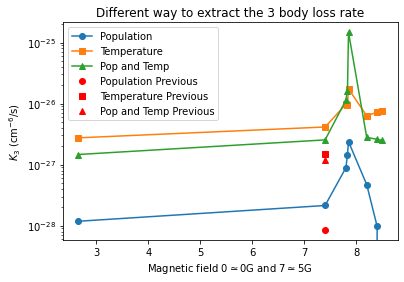

<Figure size 432x288 with 0 Axes>

In [177]:
plt.figure()
plt.semilogy(resultsDF_lin_fieldScan['compz'], resultsDF_lin_fieldScan['K3_pop'], 'o-', label = 'Population')
plt.semilogy(resultsDF_lin_fieldScan['compz'], resultsDF_lin_fieldScan['K3_temperature'], 's-', label = 'Temperature')
plt.semilogy(resultsDF_lin_fieldScan['compz'], resultsDF_lin_fieldScan['K3_popAndTemp'], '^-', label = 'Pop and Temp')
plt.semilogy(7.4, results['beta'][0], 'o', color = 'red', label = 'Population Previous')
plt.semilogy(7.4, 1.5*10**(-27), 's', color = 'red', label = 'Temperature Previous')
plt.semilogy(7.4, 1.2*10**(-27), '^', color = 'red', label = 'Pop and Temp Previous')
plt.legend()
plt.ylabel('$K_3$ (cm$^{-6}$/s)')
plt.xlabel('Magnetic field 0$\simeq$0G and 7$\simeq$5G')
plt.title("Different way to extract the 3 body loss rate")
#plt.xlim(7.3, 8)
plt.savefig("3body_coeff.jpg", dpi = 300)
plt.figure()

In [30]:
df_fieldScan['compz'].unique()

array([8.5 , 7.85, 8.4 , 2.65, 7.83, 7.8 , 7.4 , 8.2 ])

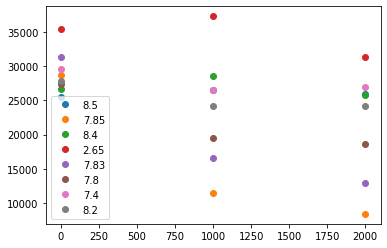

In [40]:
plt.figure()
for compz in df_fieldScan['compz'].unique():
    df_temp = getSubDF(df_fieldScan, ['compz'], [compz])
    df_temp = df_temp.groupby(['BECHoldTime']).mean().reset_index()
    plt.plot(df_temp['BECHoldTime'], df_temp['nCount'], 'o', label = compz)
plt.legend()
plt.show()

In [41]:
resultsDF_pure_alpha

,N0,alpha,gamma,compz,temperature,density,beta
0,44130.557354,0.000031,3.677752e-14,7.4,6.058278e-07,6.615451e+13,8.504019e-29


In [ ]:
plt.figure()
i = 0
for compz in compzList:
    df_temp = getSubDF(df_3b, ['compz'], [compz])
    plt.plot(df_temp['BECHoldTime'], df_temp['temperature']**3*df_temp['nCount']**(-2), 'o', color = colors[i], label = str(compz))
    i += 1
plt.legend()
plt.xlim(0,3000)
plt.ylim(0,2)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('temperature (nK)')
plt.show()

# OLD

### Density measurement based on in situ imaging

Other way to calculate the volume, simply use the in situ imaging with the density being $N/V \simeq N/(2a_x 2a_y 2a_z)^2) = \frac{N}{8(7\mu m 7.3\mu m 18\mu m)}$. Actually more precise calculation gives: $n = \frac{N}{(2\pi)^{3/2}\sigma_x\sigma_y\sigma_z}e^{-\frac{1}{2}(\frac{x^2}{\sigma_x^2}+\frac{y^2}{\sigma_y^2}+\frac{z^2}{\sigma_z^2})}$ and therefore $<n^2> = \frac{1}{N}\int n^3 d\tau = \frac{N^2}{3^{3/2}(2\pi)^3(\sigma_x\sigma_y\sigma_z)^2}$.

In [219]:
sigma_x = 7.1*10**(-4) # in cm
sigma_y = 18*10**(-4) # in cm
sigma_z = 7.3*10**(-4) # in cm

sigma_x = 3.62*10**(-4) # in cm
sigma_y = 9.57*10**(-4) # in cm
sigma_z = 3.62*(6.1/5.2)*10**(-4) # in cm


results['densityVolume'] = results['N0']/((2*np.pi)**(3/2)*sigma_x*sigma_y*sigma_z)  # in atoms / cm3
results['betaVolume'] = results['gamma']*10**3*(3**(3/2))/(results['densityVolume']/results['N0'])**2  # in atoms / cm3

In [220]:
results
# You should only trust the initial 1.9 measurement, the other cloud could have changed size
# (although I checked with 7.72 and this one looks similar)

,N0,alpha,gamma,compz,temperature,density,beta,densityVolume,betaVolume
0,32441.595232,0.000054,3.419598e-15,3.5,2.025893e-07,2.968958e+13,2.121549e-29,1.400157e+13,9.539106e-29


### Check consistency of the 2 approaches

In [221]:
T = results['temperature'][0]  # Take the temperature of the coldest orginial cloud at 1.9
sigma_x_test = np.sqrt(k_B*T/(m*omega_x**2))
sigma_y_test = np.sqrt(k_B*T/(m*omega_y**2))
sigma_z_test = np.sqrt(k_B*T/(m*omega_z**2))

print("The measured sigma_x is " + str(round(sigma_x*10**4, 1)) + " um and the calculated one is " + str(round(sigma_x_test*10**6, 1)) + " um")
print("The measured sigma_y is " + str(round(sigma_y*10**4, 1)) + " um and the calculated one is " + str(round(sigma_y_test*10**6, 1)) + " um")
print("The measured sigma_z is " + str(round(sigma_z*10**4, 1)) + " um and the calculated one is " + str(round(sigma_z_test*10**6, 1)) + " um")

The measured sigma_x is 3.6 um and the calculated one is 2.6 um
The measured sigma_y is 9.6 um and the calculated one is 6.4 um
The measured sigma_z is 4.2 um and the calculated one is 3.6 um


### End

In [37]:
import numpy as np
m = 164*1.67*10**(-27)
k_B = 1.38*10**(-23)
hbar = 6.626*10**(-34)/(2*np.pi)
sigma_0 = 4
T = 200*10**(-9)
omega_x = 2*np.pi*28
np.sqrt(k_B*T/(m*omega_x**2))

1.8044152203236358e-05

In [38]:
np.sqrt(k_B*T/(m*omega_x**2))*(0.105/5)**(1/4)

6.868965030561809e-06